# Color Space

## Overview
- Comprehensive exploration of digital image representation, color theory, and file formats
- Learn core concepts behind digital image processing and computer vision
- Understand technical aspects of image handling and storage

## Dependencies

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple, Union, Optional, DefaultDict
from scipy.stats import entropy
import plotly.graph_objects as go
import pandas as pd
import random
import time

# Configure matplotlib with a more modern style
plt.style.use('seaborn-v0_8')  # Updated to use non-deprecated style

## Color Space Converter

In [44]:
class ColorSpaceConverter:
    """A class for converting images between different color spaces.
    
    This class provides static methods for converting RGB images to various color spaces
    including HSV, HSL, HSI, LAB, LMS, YCoCg, YCrCb, and CMYK. All methods expect input
    images as numpy arrays in RGB format with values in range [0, 255].
    """
    
    @staticmethod
    def _normalize_rgb(rgb_img: np.ndarray) -> np.ndarray:
        """Normalize RGB values to range [0, 1]."""
        return rgb_img.astype(float) / 255.0
    
    @staticmethod
    def _create_output_array(*channels: np.ndarray) -> np.ndarray:
        """Stack channels and convert to uint8."""
        return np.dstack(channels).astype(np.uint8)
    
    @staticmethod
    def rgb_to_hsv(rgb_img: np.ndarray) -> np.ndarray:
        """Convert RGB to HSV color space."""
        return cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    
    @staticmethod
    def rgb_to_hsl(rgb_img: np.ndarray) -> np.ndarray:
        """Convert RGB to HSL color space."""
        rgb_norm = ColorSpaceConverter._normalize_rgb(rgb_img)
        r, g, b = np.moveaxis(rgb_norm, -1, 0)  # More efficient channel separation
        
        cmax = np.maximum.reduce([r, g, b])
        cmin = np.minimum.reduce([r, g, b])
        delta = cmax - cmin
        
        # Calculate Lightness
        l = (cmax + cmin) / 2
        
        # Calculate Saturation
        s = np.zeros_like(delta)
        valid_mask = (l > 0) & (l < 1)
        s[valid_mask] = delta[valid_mask] / (1 - np.abs(2 * l[valid_mask] - 1))
        
        # Calculate Hue
        h = np.zeros_like(delta)
        mask = delta != 0
        
        # Vectorized hue calculation
        h[mask & (cmax == r)] = ((g[mask & (cmax == r)] - b[mask & (cmax == r)]) / 
                                delta[mask & (cmax == r)]) % 6
        h[mask & (cmax == g)] = ((b[mask & (cmax == g)] - r[mask & (cmax == g)]) / 
                                delta[mask & (cmax == g)]) + 2
        h[mask & (cmax == b)] = ((r[mask & (cmax == b)] - g[mask & (cmax == b)]) / 
                                delta[mask & (cmax == b)]) + 4
        
        h = h * 60  # Convert to degrees
        h[h < 0] += 360
        
        return ColorSpaceConverter._create_output_array(h/360*255, s*255, l*255)
    
    @staticmethod
    def rgb_to_hsi(rgb_img: np.ndarray) -> np.ndarray:
        """Convert RGB to HSI color space."""
        rgb_norm = ColorSpaceConverter._normalize_rgb(rgb_img)
        r, g, b = np.moveaxis(rgb_norm, -1, 0)
        
        # Calculate Intensity
        intensity = np.mean([r, g, b], axis=0)
        
        # Calculate Saturation
        min_rgb = np.minimum.reduce([r, g, b])
        saturation = np.zeros_like(intensity)
        mask = intensity > 0
        saturation[mask] = 1 - (min_rgb[mask] / intensity[mask])
        
        # Calculate Hue
        eps = 1e-8
        num = 0.5 * ((r - g) + (r - b))
        den = np.sqrt((r - g)**2 + (r - b)*(g - b) + eps)
        theta = np.arccos(np.clip(num / (den + eps), -1.0, 1.0))
        
        h = np.where(b <= g, theta, 2*np.pi - theta)
        h = np.nan_to_num(h)
        
        return ColorSpaceConverter._create_output_array(h/2/np.pi*255, saturation*255, intensity*255)
    
    @staticmethod
    def rgb_to_lab(rgb_img: np.ndarray) -> np.ndarray:
        """Convert RGB to LAB color space."""
        return cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LAB)
    
    @staticmethod
    def rgb_to_lms(rgb_img: np.ndarray) -> np.ndarray:
        """Convert RGB to LMS color space using Hunt-Pointer-Estevez transformation."""
        rgb_norm = ColorSpaceConverter._normalize_rgb(rgb_img)
        
        # Hunt-Pointer-Estevez transformation matrix
        matrix = np.array([
            [0.4002, 0.7076, -0.0808],
            [-0.2263, 1.1653, 0.0457],
            [0.0, 0.0, 0.9182]
        ])
        
        # Efficient matrix multiplication
        lms = np.einsum('ij,...j->...i', matrix, rgb_norm.reshape(-1, 3)).reshape(rgb_img.shape)
        return np.clip(lms * 255, 0, 255).astype(np.uint8)
    
    @staticmethod
    def rgb_to_ycocg(rgb_img: np.ndarray) -> np.ndarray:
        """Convert RGB to YCoCg color space."""
        rgb_norm = ColorSpaceConverter._normalize_rgb(rgb_img)
        r, g, b = np.moveaxis(rgb_norm, -1, 0)
        
        y = 0.25 * r + 0.5 * g + 0.25 * b
        co = 0.5 * (r - b) + 0.5
        cg = 0.5 * (2*g - r - b) + 0.5
        
        return ColorSpaceConverter._create_output_array(y*255, co*255, cg*255)
    
    @staticmethod
    def rgb_to_ycrcb(rgb_img: np.ndarray) -> np.ndarray:
        """Convert RGB to YCrCb color space."""
        return cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YCrCb)
    
    @staticmethod
    def rgb_to_cmyk(rgb_img: np.ndarray) -> np.ndarray:
        """Convert RGB to CMYK color space."""
        rgb_norm = ColorSpaceConverter._normalize_rgb(rgb_img)
        r, g, b = np.moveaxis(rgb_norm, -1, 0)
        
        k = 1 - np.maximum.reduce([r, g, b])
        mask = k != 1
        
        # Vectorized CMYK calculation
        c = np.zeros_like(k)
        m = np.zeros_like(k)
        y = np.zeros_like(k)
        
        c[mask] = (1 - r[mask] - k[mask]) / (1 - k[mask])
        m[mask] = (1 - g[mask] - k[mask]) / (1 - k[mask])
        y[mask] = (1 - b[mask] - k[mask]) / (1 - k[mask])
        
        return ColorSpaceConverter._create_output_array(c*255, m*255, y*255, k*255)
    
    @staticmethod
    def cmyk_to_rgb(cmyk_img: np.ndarray) -> np.ndarray:
        """Convert CMYK to RGB color space."""
        cmyk_norm = ColorSpaceConverter._normalize_rgb(cmyk_img)
        c, m, y, k = np.moveaxis(cmyk_norm, -1, 0)
        
        r = (1 - c) * (1 - k)
        g = (1 - m) * (1 - k)
        b = (1 - y) * (1 - k)
        
        return ColorSpaceConverter._create_output_array(r*255, g*255, b*255)

## Grayscale Converter 

In [45]:
class GrayscaleConverter:
    """A class for converting RGB images to grayscale using various methods.
    
    This class provides multiple approaches to convert color images to grayscale,
    each with different characteristics and use cases. Methods are implemented as
    static methods for efficiency and ease of use.
    """
    
    # Standard coefficients for different conversion methods
    ITU_BT601_COEFFS = np.array([0.299, 0.587, 0.114])
    REC_709_COEFFS = np.array([0.2126, 0.7152, 0.0722])
    
    @staticmethod
    def _validate_input(rgb_img: np.ndarray) -> None:
        """Validate input image format and values.
        
        Args:
            rgb_img: Input RGB image as numpy array
            
        Raises:
            ValueError: If image format is invalid
        """
        if rgb_img.ndim != 3 or rgb_img.shape[2] != 3:
            raise ValueError("Input must be an RGB image with shape (H, W, 3)")
        if rgb_img.dtype != np.uint8:
            raise ValueError("Input image must be uint8 with values in [0, 255]")
    
    @staticmethod
    def basic_average(rgb_img: np.ndarray) -> np.ndarray:
        """Convert to grayscale by averaging RGB channels.
        
        Simple arithmetic mean of R, G, and B channels. Fast but doesn't account
        for human perception of color.
        
        Args:
            rgb_img: RGB image as numpy array with values in [0, 255]
            
        Returns:
            Grayscale image as numpy array
        """
        GrayscaleConverter._validate_input(rgb_img)
        return np.mean(rgb_img, axis=2).astype(np.uint8)
    
    @staticmethod
    def weighted_rgb(rgb_img: np.ndarray) -> np.ndarray:
        """Convert to grayscale using ITU-R BT.601 weighted conversion.
        
        Uses standardized weights that account for human perception of color.
        This method is optimized for standard-definition television.
        
        Args:
            rgb_img: RGB image as numpy array with values in [0, 255]
            
        Returns:
            Grayscale image as numpy array
        """
        GrayscaleConverter._validate_input(rgb_img)
        return cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    
    @staticmethod
    def luminance(rgb_img: np.ndarray) -> np.ndarray:
        """Convert to grayscale using Rec. 709 luminance-preserving conversion.
        
        Uses coefficients optimized for high-definition content and modern displays.
        This method better preserves perceived brightness relationships.
        
        Args:
            rgb_img: RGB image as numpy array with values in [0, 255]
            
        Returns:
            Grayscale image as numpy array
        """
        GrayscaleConverter._validate_input(rgb_img)
        # Use efficient dot product for weighted sum
        return np.dot(rgb_img, GrayscaleConverter.REC_709_COEFFS).astype(np.uint8)
    
    @staticmethod
    def desaturate(rgb_img: np.ndarray) -> np.ndarray:
        """Convert to grayscale using the desaturation method.
        
        Calculates grayscale as (max(R,G,B) + min(R,G,B)) / 2. This method
        preserves the relative relationships between colors well.
        
        Args:
            rgb_img: RGB image as numpy array with values in [0, 255]
            
        Returns:
            Grayscale image as numpy array
        """
        GrayscaleConverter._validate_input(rgb_img)
        rgb_float = rgb_img.astype(float)
        return ((np.max(rgb_float, axis=2) + np.min(rgb_float, axis=2)) / 2).astype(np.uint8)
    
    @staticmethod
    def value_component(rgb_img: np.ndarray) -> np.ndarray:
        """Extract the Value component from HSV color space.
        
        Returns the maximum of R, G, and B channels, which represents the
        brightness of the image in HSV color space.
        
        Args:
            rgb_img: RGB image as numpy array with values in [0, 255]
            
        Returns:
            Grayscale image as numpy array
        """
        GrayscaleConverter._validate_input(rgb_img)
        hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
        return hsv[..., 2]
    
    @staticmethod
    def lightness_component(rgb_img: np.ndarray) -> np.ndarray:
        """Extract the Lightness component from LAB color space.
        
        Uses the L channel from LAB color space, which is designed to
        better match human perception of lightness.
        
        Args:
            rgb_img: RGB image as numpy array with values in [0, 255]
            
        Returns:
            Grayscale image as numpy array
        """
        GrayscaleConverter._validate_input(rgb_img)
        lab = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LAB)
        return lab[..., 0]
    
    @classmethod
    def compare_methods(cls, rgb_img: np.ndarray) -> Dict[str, np.ndarray]:
        """Compare all grayscale conversion methods for a single image.
        
        Args:
            rgb_img: RGB image as numpy array with values in [0, 255]
            
        Returns:
            Dictionary mapping method names to resulting grayscale images
        """
        cls._validate_input(rgb_img)
        return {
            'Average': cls.basic_average(rgb_img),
            'Weighted': cls.weighted_rgb(rgb_img),
            'Luminance': cls.luminance(rgb_img),
            'Desaturate': cls.desaturate(rgb_img),
            'Value': cls.value_component(rgb_img),
            'Lightness': cls.lightness_component(rgb_img)
        }

## Colorspace Analyzer

In [46]:
class ColorSpaceAnalyzer:
    """A comprehensive analyzer for studying color space properties and relationships.
    
    This class provides tools for analyzing images across different color spaces,
    computing statistical relationships, and generating comparative visualizations.
    It combines color space conversion capabilities with statistical analysis tools.
    """
    
    def __init__(self):
        """Initialize the analyzer with color space definitions and converters."""
        self.converter = ColorSpaceConverter()
        self.gray_converter = GrayscaleConverter()
        
        # Define color spaces and their properties
        self.color_spaces = {
            'RGB': self._create_space_info(['R', 'G', 'B'], lambda x: x),
            'HSV': self._create_space_info(['H', 'S', 'V'], self.converter.rgb_to_hsv),
            'HSL': self._create_space_info(['H', 'S', 'L'], self.converter.rgb_to_hsl),
            'HSI': self._create_space_info(['H', 'S', 'I'], self.converter.rgb_to_hsi),
            'LAB': self._create_space_info(['L', 'a', 'b'], self.converter.rgb_to_lab),
            'LMS': self._create_space_info(['L', 'M', 'S'], self.converter.rgb_to_lms),
            'YCoCg': self._create_space_info(['Y', 'Co', 'Cg'], self.converter.rgb_to_ycocg),
            'YCrCb': self._create_space_info(['Y', 'Cr', 'Cb'], self.converter.rgb_to_ycrcb),
            'CMYK': self._create_space_info(['C', 'M', 'Y', 'K'], self.converter.rgb_to_cmyk)
        }

    def _create_space_info(self, channels: List[str], convert_func: callable) -> Dict:
        """Create a standardized color space information dictionary.
        
        Args:
            channels: List of channel names
            convert_func: Conversion function from RGB to this color space
            
        Returns:
            Dictionary with color space information
        """
        return {
            'channels': channels,
            'convert': convert_func,
            'properties': {
                'num_channels': len(channels),
                'is_perceptual': any(c in channels for c in ['L', 'V', 'Y']),
                'has_hue': 'H' in channels
            }
        }

    def _validate_image(self, image: np.ndarray) -> None:
        """Validate input image format and values.
        
        Args:
            image: Input image array
            
        Raises:
            ValueError: If image format is invalid
        """
        if not isinstance(image, np.ndarray):
            raise ValueError("Input must be a numpy array")
        if image.ndim != 3 or image.shape[2] != 3:
            raise ValueError("Input must be an RGB image with shape (H, W, 3)")
        if image.dtype != np.uint8:
            raise ValueError("Input image must be uint8 with values in [0, 255]")

    def _calculate_channel_statistics(self, channel_data: np.ndarray) -> Dict:
        """Calculate comprehensive statistics for a single channel.
        
        Args:
            channel_data: Single channel image data
            
        Returns:
            Dictionary of statistical measures
        """
        return {
            'mean': float(np.mean(channel_data)),
            'std': float(np.std(channel_data)),
            'min': float(np.min(channel_data)),
            'max': float(np.max(channel_data)),
            'median': float(np.median(channel_data)),
            'entropy': float(self._calculate_entropy(channel_data)),
            'dynamic_range': float(np.ptp(channel_data)),
            'quartiles': np.percentile(channel_data, [25, 50, 75]).tolist()
        }

    def _calculate_entropy(self, data: np.ndarray, bins: int = 256) -> float:
        """Calculate Shannon entropy of the data.
        
        Args:
            data: Input data array
            bins: Number of bins for histogram
            
        Returns:
            Entropy value
        """
        hist = np.histogram(data, bins=bins, density=True)[0]
        hist = hist[hist > 0]
        return -np.sum(hist * np.log2(hist))

    def calculate_mutual_information(self, x: np.ndarray, y: np.ndarray, 
                                  bins: int = 50) -> float:
        """Calculate normalized mutual information between two channels.
        
        Args:
            x: First channel data
            y: Second channel data
            bins: Number of bins for histogram
            
        Returns:
            Normalized mutual information value
        """
        # Calculate joint histogram
        hist_2d, _, _ = np.histogram2d(x.ravel(), y.ravel(), bins=bins)
        
        # Calculate marginal histograms
        hist_x = hist_2d.sum(axis=1)
        hist_y = hist_2d.sum(axis=0)
        
        # Normalize histograms with small epsilon to avoid log(0)
        eps = 1e-10
        hist_2d_norm = hist_2d / (hist_2d.sum() + eps)
        hist_x_norm = hist_x / (hist_x.sum() + eps)
        hist_y_norm = hist_y / (hist_y.sum() + eps)
        
        # Calculate entropies
        H_x = entropy(hist_x_norm + eps)
        H_y = entropy(hist_y_norm + eps)
        H_xy = entropy(hist_2d_norm.ravel() + eps)
        
        # Calculate and normalize mutual information
        MI = H_x + H_y - H_xy
        return MI / min(H_x, H_y)

    def analyze_image(self, image: np.ndarray) -> Dict:
        """Perform comprehensive analysis of an image in all color spaces.
        
        Args:
            image: Input RGB image
            
        Returns:
            Dictionary containing analysis results for each color space
        """
        self._validate_image(image)
        results = {}
        
        for space_name, space_info in self.color_spaces.items():
            # Convert image to current color space
            converted = space_info['convert'](image)
            
            # Initialize space results
            space_results = {
                'channels': space_info['channels'],
                'properties': space_info['properties'],
                'data': converted,
                'channel_stats': [],
                'global_stats': {}
            }
            
            # Analyze each channel
            for i, channel in enumerate(space_info['channels']):
                channel_data = converted[..., i] if converted.ndim == 3 else converted
                space_results['channel_stats'].append(
                    self._calculate_channel_statistics(channel_data)
                )
            
            # Calculate global statistics
            space_results['global_stats'] = {
                'total_entropy': sum(stat['entropy'] for stat in space_results['channel_stats']),
                'mean_dynamic_range': np.mean([stat['dynamic_range'] 
                                             for stat in space_results['channel_stats']]),
                'channel_correlations': self._calculate_channel_correlations(converted)
            }
            
            results[space_name] = space_results
            
        return results

    def _calculate_channel_correlations(self, color_space_data: np.ndarray) -> np.ndarray:
        """Calculate correlation matrix between channels in a color space.
        
        Args:
            color_space_data: Color space image data
            
        Returns:
            Correlation matrix
        """
        if color_space_data.ndim == 2:
            return np.array([[1.0]])
        
        n_channels = color_space_data.shape[2]
        correlations = np.zeros((n_channels, n_channels))
        
        for i in range(n_channels):
            for j in range(n_channels):
                correlations[i, j] = np.corrcoef(
                    color_space_data[..., i].ravel(),
                    color_space_data[..., j].ravel()
                )[0, 1]
        
        return correlations

    def get_channel_matrices(self, image: np.ndarray
                           ) -> Tuple[np.ndarray, np.ndarray, List[str]]:
        """Calculate correlation and mutual information matrices for all channels.
        
        Args:
            image: Input RGB image
            
        Returns:
            Tuple of (correlation matrix, mutual information matrix, channel labels)
        """
        self._validate_image(image)
        results = self.analyze_image(image)
        
        # Collect all channels
        channels = []
        channel_labels = []
        
        for space_name, space_data in results.items():
            space_channels = space_data['data']
            
            if space_channels.ndim == 3:
                for i, channel_name in enumerate(space_data['channels']):
                    channels.append(space_channels[..., i].ravel())
                    channel_labels.append(f"{space_name}_{channel_name}")
            else:
                channels.append(space_channels.ravel())
                channel_labels.append(space_name)
        
        n_channels = len(channels)
        correlation_matrix = np.zeros((n_channels, n_channels))
        mutual_info_matrix = np.zeros((n_channels, n_channels))
        
        # Calculate matrices using vectorized operations where possible
        for i in range(n_channels):
            for j in range(i, n_channels):
                correlation_matrix[i, j] = np.corrcoef(channels[i], channels[j])[0, 1]
                mutual_info_matrix[i, j] = self.calculate_mutual_information(
                    channels[i], channels[j]
                )
                
                if i != j:
                    correlation_matrix[j, i] = correlation_matrix[i, j]
                    mutual_info_matrix[j, i] = mutual_info_matrix[i, j]
        
        return correlation_matrix, mutual_info_matrix, channel_labels

## Color space Visualizer

In [47]:
class ColorSpaceVisualizer:
    """A class for creating comprehensive visualizations of color space analysis.
    
    This class provides methods for visualizing various aspects of color spaces,
    including channel distributions, color space comparisons, and statistical
    relationships. It works in conjunction with the ColorSpaceAnalyzer to create
    informative visual representations of color space properties.
    """
    
    def __init__(self, analyzer: ColorSpaceAnalyzer):
        """Initialize the visualizer with an analyzer instance.
        
        Args:
            analyzer: ColorSpaceAnalyzer instance for performing analysis
        """
        self.analyzer = analyzer
        self.figure_size = (20, 10)
        self.style_config = {
            'font.size': 10,
            'axes.titlesize': 12,
            'figure.titlesize': 14,
            'axes.labelsize': 10,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8
        }
        plt.rcParams.update(self.style_config)

    def plot_color_space_histograms(self, results: Dict, save_path: Optional[str] = None) -> None:
        """Create stacked channel histograms for each color space in a grid layout.
        
        Similar to Photoshop's histogram view, showing channel distributions stacked
        within each color space plot. Handles outlier clipping for better visualization.
        """
        # Calculate grid dimensions
        n_spaces = len(results)
        n_cols = min(3, n_spaces)
        n_rows = (n_spaces + n_cols - 1) // n_cols
        
        fig = plt.figure(figsize=(5*n_cols, 3*n_rows))
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        
        for idx, (space_name, space_data) in enumerate(results.items(), 1):
            ax = plt.subplot(n_rows, n_cols, idx)
            
            for i, channel in enumerate(space_data['channels']):
                channel_data = (space_data['data'][..., i] if space_data['data'].ndim == 3 
                            else space_data['data'])
                
                # Clip outliers using percentile method
                q1, q3 = np.percentile(channel_data, [1, 99])
                clipped_data = np.clip(channel_data, q1, q3)
                
                # Calculate histogram
                hist, bins = np.histogram(clipped_data, bins=256, density=True)
                
                # Plot with transparency
                color = {'R': 'red', 'G': 'green', 'B': 'blue',
                        'H': 'purple', 'S': 'orange', 'V': 'gray',
                        'L': 'black'}.get(channel[0], 'gray')
                
                ax.plot(bins[:-1], hist, color=color, alpha=0.7, 
                    label=f"{channel} (μ={np.mean(channel_data):.1f}, σ={np.std(channel_data):.1f})")
            
            ax.set_title(f'{space_name}', fontsize=10, pad=5)
            ax.set_xlim(0, 255)
            ax.set_xticks([0, 128, 255])
            ax.grid(True, alpha=0.2)
            ax.legend(loc='upper right', fontsize=8)
            
            # Remove excess whitespace
            ax.set_ylim(bottom=0)
            ax.margins(x=0, y=0)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(f'{save_path}_histograms.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_relationship_matrices(self, image: np.ndarray, save_path: Optional[str] = None) -> None:
        """Plot separate detailed relationship matrices including grayscale conversions.
        
        Creates four separate high-resolution matrices:
        1. Correlation Matrix: Shows linear relationships (-1 to 1)
        2. Mutual Information Matrix: Shows shared information content (0 to 1)
        3. Dissimilarity Matrix: Shows independence between channels (0 to 1)
        4. Color Space Similarity Matrix: Overall relationship between spaces (0 to 1)
        """
        # Get matrices including grayscale conversions
        corr_matrix, mi_matrix, labels = self.analyzer.get_channel_matrices(image)
        
        # Add grayscale conversion methods to the analysis
        gray_results = self.analyzer.gray_converter.compare_methods(image)
        for method_name, gray_img in gray_results.items():
            flat_gray = gray_img.ravel()
            
            # Extend matrices with grayscale correlations
            corr_gray = np.array([np.corrcoef(flat_gray, 
                                channel_data.ravel())[0,1] 
                                for channel_data in channels])
            mi_gray = np.array([self.analyzer.calculate_mutual_information(
                            flat_gray, channel_data.ravel())
                            for channel_data in channels])
            
            # Append to matrices
            corr_matrix = np.vstack([corr_matrix, corr_gray])
            corr_matrix = np.hstack([corr_matrix, 
                                    np.append(corr_gray, 1).reshape(-1,1)])
            mi_matrix = np.vstack([mi_matrix, mi_gray])
            mi_matrix = np.hstack([mi_matrix, 
                                np.append(mi_gray, 1).reshape(-1,1)])
            labels.append(f'Gray_{method_name}')
        
        # Plot each matrix separately with high resolution
        matrices = [
            (corr_matrix, 'Correlation', 'RdBu_r', 
            'Linear relationship between channels\nHigh: Strong positive correlation (1.0)\nLow: Strong negative correlation (-1.0)'),
            (mi_matrix, 'Mutual_Information', 'viridis',
            'Shared information between channels\nHigh: Strong dependency (1.0)\nLow: Independence (0.0)'),
            (1 - np.abs(corr_matrix), 'Dissimilarity', 'YlOrRd',
            'Channel independence\nHigh: Independent channels (1.0)\nLow: Dependent channels (0.0)'),
            (self._calculate_space_similarity(corr_matrix, mi_matrix, labels), 
            'Color_Space_Similarity', 'YlOrRd',
            'Overall relationship between color spaces\nHigh: Similar representations (1.0)\nLow: Different representations (0.0)')
        ]
        
        for matrix, name, cmap, description in matrices:
            plt.figure(figsize=(12, 10))
            plt.suptitle(f'{name} Matrix\n{description}', fontsize=12, y=0.95)
            
            sns.heatmap(matrix, xticklabels=labels, yticklabels=labels,
                    cmap=cmap, center=0 if name == 'Correlation' else None,
                    vmin=-1 if name == 'Correlation' else 0, vmax=1,
                    annot=True, fmt='.2f', square=True,
                    cbar_kws={'label': name})
            
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            
            # Remove excess whitespace
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            
            if save_path:
                plt.savefig(f'{save_path}_{name.lower()}_matrix.png', 
                        dpi=300, bbox_inches='tight')
            plt.show()
            
            # Print key relationships
            self._print_matrix_analysis(matrix, labels, name)

    def _print_matrix_analysis(self, matrix: np.ndarray, labels: List[str], 
                            matrix_type: str) -> None:
        """Print detailed analysis of matrix relationships."""
        np.fill_diagonal(matrix, np.nan)  # Ignore self-relationships
        
        if matrix_type == 'Correlation':
            max_idx = np.nanargmax(np.abs(matrix))
            min_idx = np.nanargmin(np.abs(matrix))
        else:
            max_idx = np.nanargmax(matrix)
            min_idx = np.nanargmin(matrix)
        
        i, j = np.unravel_index(max_idx, matrix.shape)
        print(f"\nStrongest {matrix_type}: {labels[i]} and {labels[j]} "
            f"(value = {matrix[i,j]:.3f})")
        
        i, j = np.unravel_index(min_idx, matrix.shape)
        print(f"Weakest {matrix_type}: {labels[i]} and {labels[j]} "
            f"(value = {matrix[i,j]:.3f})")

    def visualize_color_spaces_and_channels(self, image: np.ndarray, 
                                            save_path: Optional[str] = None) -> None:
            """Display each color space conversion and its individual channels in grayscale.
            
            Args:
                image: Input RGB image
                save_path: Optional path to save the visualization
            """
            results = self.analyzer.analyze_image(image)
            n_spaces = len(results)
            
            fig = plt.figure(figsize=(20, 5 * n_spaces))
            grid = plt.GridSpec(n_spaces, 5, hspace=0.3, wspace=0.3)
            
            for idx, (space_name, space_data) in enumerate(results.items()):
                # Plot original/converted full color image
                ax_main = fig.add_subplot(grid[idx, 0])
                self._plot_color_space_image(ax_main, space_name, space_data['data'])
                
                # Plot individual channels in grayscale
                for i, channel in enumerate(space_data['channels']):
                    ax_channel = fig.add_subplot(grid[idx, i+1])
                    self._plot_channel_with_stats(
                        ax_channel, 
                        channel,
                        space_data['data'][..., i] if space_data['data'].ndim == 3 else space_data['data'],
                        space_data['channel_stats'][i]
                    )
            
            plt.suptitle('Color Space Conversions and Channel Decomposition', 
                        fontsize=16, y=1.02)
            
            if save_path:
                plt.savefig(f'{save_path}_color_spaces.png', dpi=300, bbox_inches='tight')
            plt.show()
    def visualize_grayscale_conversions(self, image: np.ndarray, 
                                      save_path: Optional[str] = None) -> None:
        """Create a comparison of different grayscale conversion methods.
        
        Args:
            image: Input RGB image
            save_path: Optional path to save the visualization
        """
        grayscale_results = self.analyzer.gray_converter.compare_methods(image)
        
        fig = plt.figure(figsize=(20, 5))
        grid = plt.GridSpec(1, len(grayscale_results), wspace=0.3)
        
        for idx, (method_name, gray_img) in enumerate(grayscale_results.items()):
            ax = fig.add_subplot(grid[idx])
            
            im = ax.imshow(gray_img, cmap='gray')
            ax.set_title(f'{method_name} Method')
            ax.axis('off')
            
            plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
            
            stats = {
                'Mean': np.mean(gray_img),
                'Std': np.std(gray_img),
                'Entropy': self.analyzer._calculate_entropy(gray_img)
            }
            stats_text = '\n'.join([f'{k}: {v:.1f}' for k, v in stats.items()])
            ax.text(1.05, 0.5, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='center',
                   fontsize=8)
        
        plt.suptitle('Grayscale Conversion Methods Comparison', 
                    fontsize=16, y=1.05)
        
        if save_path:
            plt.savefig(f'{save_path}_grayscale.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_color_space_relationships(self, image: np.ndarray, 
                                        save_path: Optional[str] = None) -> None:
        """Create a detailed analysis of relationships between color spaces.
        
        Args:
            image: Input RGB image
            save_path: Optional path to save the visualization
        """
        corr_matrix, mi_matrix, labels = self.analyzer.get_channel_matrices(image)
        
        fig = plt.figure(figsize=(25, 20))
        gs = plt.GridSpec(2, 2, height_ratios=[1, 1.2])
        
        # Plot correlation matrix
        ax1 = plt.subplot(gs[0, 0])
        self._plot_correlation_matrix(ax1, corr_matrix, labels)
        
        # Plot mutual information matrix
        ax2 = plt.subplot(gs[0, 1])
        self._plot_mutual_information_matrix(ax2, mi_matrix, labels)
        
        # Plot color space similarity matrix
        ax3 = plt.subplot(gs[1, :])
        self._plot_similarity_matrix(ax3, corr_matrix, mi_matrix, labels)
        
        if save_path:
            plt.savefig(f'{save_path}_relationships.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print analysis summary
        self._print_relationship_analysis(corr_matrix, mi_matrix, labels)

    def _plot_color_space_image(self, ax: plt.Axes, space_name: str, 
                              converted_img: np.ndarray) -> None:
        """Helper method to plot color space converted image."""
        if space_name == 'RGB':
            ax.imshow(converted_img)
        elif space_name == 'CMYK':
            rgb_converted = self.analyzer.converter.cmyk_to_rgb(converted_img)
            ax.imshow(rgb_converted)
        else:
            normalized = ((converted_img - converted_img.min()) / 
                        (converted_img.max() - converted_img.min() + 1e-8))
            ax.imshow(normalized if converted_img.ndim == 3 else normalized, cmap='gray')
        ax.set_title(f'{space_name} Space')
        ax.axis('off')

    def _plot_channel_with_stats(self, ax: plt.Axes, channel: str, 
                               channel_data: np.ndarray, stats: Dict) -> None:
        """Plot a single channel in grayscale with statistics.
        
        Args:
            ax: Matplotlib axis
            channel: Channel name
            channel_data: Channel image data
            stats: Channel statistics
        """
        # Normalize data to 0-255 range if needed
        if channel_data.max() > 0:  # Avoid division by zero
            normalized_data = ((channel_data - channel_data.min()) * 
                             (255.0 / (channel_data.max() - channel_data.min())))
        else:
            normalized_data = channel_data
            
        # Display in grayscale
        im = ax.imshow(normalized_data, cmap='gray', vmin=0, vmax=255)
        ax.set_title(f'{channel} Channel')
        ax.axis('off')
        
        plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
        
        # Add statistics text
        stats_text = '\n'.join([
            f'Mean: {stats["mean"]:.1f}',
            f'Std: {stats["std"]:.1f}',
            f'Range: [{np.min(channel_data):.1f}, {np.max(channel_data):.1f}]',
            f'Entropy: {stats["entropy"]:.1f}'
        ])
        ax.text(1.05, 0.5, stats_text,
               transform=ax.transAxes,
               verticalalignment='center',
               fontsize=8)
    @staticmethod
    def _get_channel_colormap(channel: str) -> str:
        """Select appropriate colormap based on channel type."""
        channel = channel.lower()
        if channel in ['h', 'hue']:
            return 'hsv'
        elif channel in ['s', 'sat', 'saturation']:
            return 'copper'
        elif channel in ['v', 'value', 'l', 'lightness', 'intensity', 'y']:
            return 'gray'
        return 'viridis'

    def _plot_correlation_matrix(self, ax: plt.Axes, corr_matrix: np.ndarray, 
                               labels: List[str]) -> None:
        """Helper method to plot correlation matrix."""
        sns.heatmap(corr_matrix,
                   xticklabels=labels,
                   yticklabels=labels,
                   cmap='RdBu_r',
                   center=0,
                   vmin=-1,
                   vmax=1,
                   annot=True,
                   fmt='.2f',
                   ax=ax,
                   cbar_kws={'label': 'Correlation Coefficient'})
        ax.set_title('Channel Correlation Matrix', pad=20)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax.get_yticklabels(), rotation=0)

    def _plot_mutual_information_matrix(self, ax: plt.Axes, mi_matrix: np.ndarray, 
                                      labels: List[str]) -> None:
        """Helper method to plot mutual information matrix."""
        sns.heatmap(mi_matrix,
                   xticklabels=labels,
                   yticklabels=labels,
                   cmap='viridis',
                   annot=True,
                   fmt='.2f',
                   ax=ax,
                   cbar_kws={'label': 'Mutual Information'})
        ax.set_title('Channel Mutual Information Matrix', pad=20)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax.get_yticklabels(), rotation=0)

    def _plot_similarity_matrix(self, ax: plt.Axes, corr_matrix: np.ndarray, 
                              mi_matrix: np.ndarray, labels: List[str]) -> None:
        """Helper method to plot color space similarity matrix."""
        space_names = list(set(label.split('_')[0] for label in labels))
        n_spaces = len(space_names)
        similarity_matrix = np.zeros((n_spaces, n_spaces))
        
        for i, space1 in enumerate(space_names):
            for j, space2 in enumerate(space_names):
                idx1 = [k for k, label in enumerate(labels) if label.startswith(space1)]
                idx2 = [k for k, label in enumerate(labels) if label.startswith(space2)]
                
                avg_corr = np.mean(np.abs(corr_matrix[np.ix_(idx1, idx2)]))
                avg_mi = np.mean(mi_matrix[np.ix_(idx1, idx2)])
                similarity_matrix[i, j] = 0.5 * avg_corr + 0.5 * avg_mi
        
        sns.heatmap(similarity_matrix,
                   xticklabels=space_names,
                   yticklabels=space_names,
                   cmap='YlOrRd',
                   annot=True,
                   fmt='.2f',
                   ax=ax,
                   cbar_kws={'label': 'Combined Similarity Score'})
        ax.set_title('Color Space Similarity Matrix', pad=20)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax.get_yticklabels(), rotation=0)

    def analyze_color_space_relationships(self, image: np.ndarray, 
                                        save_path: Optional[str] = None) -> None:
        """Analyze relationships between color spaces and their individual channels.
        
        Creates comprehensive visualizations of relationships between color spaces
        and their channels, including grayscale conversions. Each type of relationship
        gets its own clear visualization to help understand how different color
        representations relate to each other.
        
        The analysis includes:
        1. Channel-level correlation matrix 
        2. Channel-level mutual information matrix
        3. Channel independence matrix
        4. Color space similarity matrix
        
        Args:
            image: Input RGB image
            save_path: Optional path to save visualizations
        """
        # Get color space analysis results
        results = self.analyzer.analyze_image(image)
        
        # Get grayscale conversions and add them to results
        gray_methods = self.analyzer.gray_converter.compare_methods(image)
        gray_results = {
            f'Gray_{name}': {
                'data': gray_img,
                'channels': ['Intensity'],
                'channel_stats': [{
                    'mean': np.mean(gray_img),
                    'std': np.std(gray_img),
                    'entropy': self.analyzer._calculate_entropy(gray_img)
                }]
            }
            for name, gray_img in gray_methods.items()
        }
        
        # Combine regular and grayscale results
        all_results = {**results, **gray_results}
        
        # Extract all channels and their labels
        channels = []
        channel_labels = []
        
        for space_name, data in all_results.items():
            if data['data'].ndim == 3:
                for i, channel_name in enumerate(data['channels']):
                    channels.append(data['data'][..., i].ravel())
                    channel_labels.append(f"{space_name}_{channel_name}")
            else:
                channels.append(data['data'].ravel())
                channel_labels.append(space_name)
        
        # Calculate relationship matrices
        n_channels = len(channels)
        correlation = np.zeros((n_channels, n_channels))
        mutual_info = np.zeros((n_channels, n_channels))
        
        # Fill matrices using vectorized operations where possible
        for i in range(n_channels):
            for j in range(i, n_channels):  # Use symmetry to reduce computations
                correlation[i, j] = np.corrcoef(channels[i], channels[j])[0, 1]
                correlation[j, i] = correlation[i, j]  # Matrix is symmetric
                
                mutual_info[i, j] = self.analyzer.calculate_mutual_information(
                    channels[i], channels[j]
                )
                mutual_info[j, i] = mutual_info[i, j]  # Matrix is symmetric
        
        # Calculate derived matrices
        independence = 1 - np.abs(correlation)  # High values mean more independent
        
        # Calculate color space level similarity
        space_names = list(set(label.split('_')[0] for label in channel_labels))
        n_spaces = len(space_names)
        similarity = np.zeros((n_spaces, n_spaces))
        
        for i, space1 in enumerate(space_names):
            for j, space2 in enumerate(space_names):
                idx1 = [k for k, label in enumerate(channel_labels) if label.startswith(space1)]
                idx2 = [k for k, label in enumerate(channel_labels) if label.startswith(space2)]
                
                # Combine correlation and mutual information
                avg_corr = np.mean(np.abs(correlation[np.ix_(idx1, idx2)]))
                avg_mi = np.mean(mutual_info[np.ix_(idx1, idx2)])
                similarity[i, j] = 0.5 * avg_corr + 0.5 * avg_mi
        
        # Create visualizations with clear interpretations
        matrix_configs = [
            (correlation, 'Channel Correlation',
            'Shows linear relationships between channels\n'
            'Red: Positive correlation (1.0)\n'
            'White: No correlation (0.0)\n'
            'Blue: Negative correlation (-1.0)',
            'RdBu_r', True),
            
            (mutual_info, 'Channel Information Sharing',
            'Shows shared information content between channels\n'
            'Yellow: High shared information (1.0)\n'
            'Purple: Low shared information (0.0)',
            'viridis', False),
            
            (independence, 'Channel Independence',
            'Shows how independently channels represent information\n'
            'Red: Highly independent (1.0)\n'
            'White: Dependent (0.0)',
            'YlOrRd', False),
            
            (similarity, 'Color Space Similarity',
            'Shows overall relationship between color spaces\n'
            'Red: Very similar representation (1.0)\n'
            'White: Different representation (0.0)',
            'YlOrRd', False)
        ]
        
        # Plot each matrix separately with high resolution
        for matrix, title, description, cmap, use_center in matrix_configs:
            plt.figure(figsize=(16, 14))
            
            # Create heatmap
            sns.heatmap(
                matrix,
                xticklabels=channel_labels if matrix.shape[0] == n_channels else space_names,
                yticklabels=channel_labels if matrix.shape[0] == n_channels else space_names,
                cmap=cmap,
                center=0.5 if use_center else None,
                vmin=-1 if use_center else 0,
                vmax=1,
                annot=True,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Relationship Strength'}
            )
            
            # Add title and description
            plt.title(f"{title}\n{description}", pad=20, fontsize=12)
            
            # Adjust labels for readability
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            
            # Remove excess whitespace
            plt.tight_layout()
            
            if save_path:
                clean_title = title.lower().replace(' ', '_')
                plt.savefig(f'{save_path}_{clean_title}.png', 
                        dpi=300, bbox_inches='tight')
            plt.show()
            
            # Print analysis of key relationships
            self._analyze_key_relationships(matrix, 
                                        channel_labels if matrix.shape[0] == n_channels else space_names,
                                        title)
    def _analyze_channel_relationships(self, matrix: np.ndarray, 
                                    labels: List[str]) -> None:
        """Analyze and print interesting channel relationships."""
        matrix_copy = matrix.copy()
        np.fill_diagonal(matrix_copy, np.nan)
        
        # Find strongest relationships
        max_indices = np.unravel_index(
            np.argsort(matrix_copy.ravel())[-5:],
            matrix_copy.shape
        )
        print("\nStrongest relationships:")
        for i, j in zip(max_indices[0], max_indices[1]):
            print(f"{labels[i]} and {labels[j]}: {matrix_copy[i,j]:.3f}")
        
        # Find weakest relationships
        min_indices = np.unravel_index(
            np.argsort(matrix_copy.ravel())[:5],
            matrix_copy.shape
        )
        print("\nWeakest relationships:")
        for i, j in zip(min_indices[0], min_indices[1]):
            print(f"{labels[i]} and {labels[j]}: {matrix_copy[i,j]:.3f}")
        
        # Find interesting patterns
        print("\nInteresting patterns:")
        
        # Check for highly independent channels
        independence_threshold = 0.1
        independent_pairs = np.where(np.abs(matrix_copy) < independence_threshold)
        if len(independent_pairs[0]) > 0:
            print("\nHighly independent channel pairs:")
            for i, j in zip(independent_pairs[0][:5], independent_pairs[1][:5]):
                print(f"{labels[i]} and {labels[j]}: {matrix_copy[i,j]:.3f}")
        
        # Check for strongly related channels across different color spaces
        relationship_threshold = 0.9
        related_pairs = np.where(np.abs(matrix_copy) > relationship_threshold)
        if len(related_pairs[0]) > 0:
            print("\nStrongly related channels across different color spaces:")
            for i, j in zip(related_pairs[0][:5], related_pairs[1][:5]):
                space1 = labels[i].split('_')[0]
                space2 = labels[j].split('_')[0]
                if space1 != space2:
                    print(f"{labels[i]} and {labels[j]}: {matrix_copy[i,j]:.3f}")

    def _get_interpretation_guide(self, matrix_type: str) -> str:
        """Get interpretation guide text for different matrix types."""
        guides = {
            'Color Space Correlation': 
                'High values (1.0): Strong linear relationship\n'
                'Low values (0.0): No linear relationship',
            
            'Information Sharing':
                'High values (1.0): High information overlap\n'
                'Low values (0.0): Independent information',
            
            'Color Space Independence':
                'High values (1.0): Spaces represent different information\n'
                'Low values (0.0): Spaces represent similar information',
            
            'Overall Similarity':
                'High values (1.0): Very similar color representations\n'
                'Low values (0.0): Very different color representations'
        }
        return guides.get(matrix_type, '')

    def _analyze_key_relationships(self, matrix: np.ndarray, 
                                labels: List[str], 
                                matrix_type: str) -> None:
        """Analyze and print key relationships from a matrix."""
        # Make copy to avoid modifying original
        matrix_copy = matrix.copy()
        np.fill_diagonal(matrix_copy, np.nan)
        
        # Find strongest and weakest relationships
        max_idx = np.nanargmax(matrix_copy)
        min_idx = np.nanargmin(matrix_copy)
        
        i, j = np.unravel_index(max_idx, matrix_copy.shape)
        print(f"\nStrongest {matrix_type} relationship:")
        print(f"{labels[i]} and {labels[j]}: {matrix_copy[i,j]:.3f}")
        
        i, j = np.unravel_index(min_idx, matrix_copy.shape)
        print(f"\nWeakest {matrix_type} relationship:")
        print(f"{labels[i]} and {labels[j]}: {matrix_copy[i,j]:.3f}")
    def _print_relationship_analysis(self, corr_matrix: np.ndarray, 
                                   mi_matrix: np.ndarray,
                                   dissimilarity: np.ndarray,
                                   similarity_matrix: np.ndarray,
                                   labels: List[str],
                                   space_names: List[str]) -> None:
        """Print detailed analysis of the relationships between color spaces and channels.
        
        Args:
            corr_matrix: Channel correlation matrix
            mi_matrix: Mutual information matrix
            dissimilarity: Channel dissimilarity matrix
            similarity_matrix: Color space similarity matrix
            labels: Channel labels
            space_names: Color space names
        """
        print("\nColor Space Relationship Analysis:")
        
        # Most correlated channels
        np.fill_diagonal(corr_matrix, 0)  # Ignore self-correlations
        max_corr_idx = np.unravel_index(np.argmax(np.abs(corr_matrix)), corr_matrix.shape)
        print(f"\nStrongest correlation: {labels[max_corr_idx[0]]} and {labels[max_corr_idx[1]]} "
              f"(r = {corr_matrix[max_corr_idx]:.3f})")
        
        # Most independent channels
        max_dissim_idx = np.unravel_index(np.argmax(dissimilarity), dissimilarity.shape)
        print(f"Most independent channels: {labels[max_dissim_idx[0]]} and {labels[max_dissim_idx[1]]} "
              f"(dissimilarity = {dissimilarity[max_dissim_idx]:.3f})")
        
        # Highest mutual information
        np.fill_diagonal(mi_matrix, 0)  # Ignore self-information
        max_mi_idx = np.unravel_index(np.argmax(mi_matrix), mi_matrix.shape)
        print(f"Strongest information sharing: {labels[max_mi_idx[0]]} and {labels[max_mi_idx[1]]} "
              f"(MI = {mi_matrix[max_mi_idx]:.3f})")
        
        # Color space relationships
        print("\nColor Space Similarity Analysis:")
        for i, space1 in enumerate(space_names):
            for j, space2 in enumerate(space_names):
                if i < j:  # Avoid redundant comparisons
                    similarity = similarity_matrix[i, j]
                    relationship = ("High" if similarity > 0.7 else
                                  "Medium" if similarity > 0.4 else "Low")
                    print(f"{space1} vs {space2}: {relationship} similarity "
                          f"(score = {similarity:.3f})")

## Color Analysis

In [48]:
class ColorAnalysisSystem:
    """A comprehensive system for color space analysis and visualization.
    
    This class integrates the ColorSpaceConverter, ColorSpaceAnalyzer, and
    ColorSpaceVisualizer into a single, easy-to-use interface for analyzing
    and visualizing color spaces in images.
    """
    
    def __init__(self):
        """Initialize the color analysis system with all necessary components."""
        self.analyzer = ColorSpaceAnalyzer()
        self.visualizer = ColorSpaceVisualizer(self.analyzer)
        
    def analyze_image(self, image_path: str, output_dir: Optional[str] = None) -> Dict:
        """Perform comprehensive color space analysis on an image.
        
        Args:
            image_path: Path to the input image
            output_dir: Optional directory to save visualizations
            
        Returns:
            Dictionary containing all analysis results
        """
        try:
            # Load and validate image
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not load image from {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Create output directory if needed
            if output_dir:
                output_dir = Path(output_dir)
                output_dir.mkdir(parents=True, exist_ok=True)
                base_name = Path(image_path).stem
                save_path = str(output_dir / base_name)
            else:
                save_path = None
            
            # Perform analysis
            results = self.analyzer.analyze_image(image)
            
            # Create visualizations
            self.visualizer.plot_color_space_histograms(results, save_path)
            self.visualizer.visualize_color_spaces_and_channels(image, save_path)
            self.visualizer.visualize_grayscale_conversions(image, save_path)
            self.visualizer.analyze_color_space_relationships(image, save_path)
            
            return results
            
        except Exception as e:
            print(f"Error analyzing image: {str(e)}")
            raise
    def analyze_random_image(self, image_dir: str = "images", 
                           output_dir: Optional[str] = None) -> Dict:
        """Analyze a randomly selected image from the specified directory.
        
        This method will:
        1. Select a random image from the directory
        2. Perform full color space analysis
        3. Generate visualizations
        4. Save results if output_dir is specified
        
        Args:
            image_dir: Directory containing images
            output_dir: Optional directory to save results
            
        Returns:
            Dictionary containing analysis results and the selected image path
        """
        # Get list of all image files
        image_dir = Path(image_dir)
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
        image_files = [f for f in image_dir.glob('*') 
                      if f.suffix.lower() in valid_extensions]
        
        if not image_files:
            raise ValueError(f"No valid images found in {image_dir}")
        
        # Select random image
        selected_image = random.choice(image_files)
        print(f"\nAnalyzing random image: {selected_image.name}")
        
        # Perform analysis
        results = self.analyze_image(str(selected_image), output_dir)
        results['selected_image'] = str(selected_image)
        
        return results
    
    def analyze_folder(self, image_dir: str = "images", 
                      output_dir: Optional[str] = None) -> Dict:
        """Analyze all images in a folder and compute aggregate statistics.
        
        This method will:
        1. Process all images in the directory
        2. Compute average values for each color space
        3. Generate summary visualizations
        4. Save aggregate results
        
        Args:
            image_dir: Directory containing images
            output_dir: Optional directory to save results
            
        Returns:
            Dictionary containing aggregate analysis results
        """
        image_dir = Path(image_dir)
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
        image_files = [f for f in image_dir.glob('*') 
                      if f.suffix.lower() in valid_extensions]
        
        if not image_files:
            raise ValueError(f"No valid images found in {image_dir}")
        
        # Initialize aggregation structures
        aggregate_results = {
            'n_images': 0,
            'color_spaces': {},
            'failed_images': [],
            'processing_time': 0
        }
        
        start_time = time.time()
        
        # Process each image
        for image_path in image_files:
            try:
                print(f"\nProcessing {image_path.name}...")
                image_results = self.analyze_image(
                    str(image_path),
                    output_dir=f"{output_dir}/{image_path.stem}" if output_dir else None
                )
                
                # Aggregate results for each color space
                for space_name, space_data in image_results.items():
                    if space_name not in aggregate_results['color_spaces']:
                        aggregate_results['color_spaces'][space_name] = {
                            'channel_stats': [],
                            'global_stats': defaultdict(list)
                        }
                    
                    # Aggregate channel statistics
                    for i, stats in enumerate(space_data['channel_stats']):
                        if len(aggregate_results['color_spaces'][space_name]['channel_stats']) <= i:
                            aggregate_results['color_spaces'][space_name]['channel_stats'].append(
                                defaultdict(list)
                            )
                        
                        for stat_name, value in stats.items():
                            aggregate_results['color_spaces'][space_name]['channel_stats'][i][stat_name].append(value)
                    
                    # Aggregate global statistics
                    for stat_name, value in space_data['global_stats'].items():
                        aggregate_results['color_spaces'][space_name]['global_stats'][stat_name].append(value)
                
                aggregate_results['n_images'] += 1
                
            except Exception as e:
                print(f"Failed to process {image_path.name}: {str(e)}")
                aggregate_results['failed_images'].append({
                    'path': str(image_path),
                    'error': str(e)
                })
        
        # Compute averages and standard deviations
        for space_name in aggregate_results['color_spaces']:
            # Process channel statistics
            for channel_stats in aggregate_results['color_spaces'][space_name]['channel_stats']:
                for stat_name in channel_stats:
                    values = channel_stats[stat_name]
                    channel_stats[stat_name] = {
                        'mean': float(np.mean(values)),
                        'std': float(np.std(values)),
                        'min': float(np.min(values)),
                        'max': float(np.max(values))
                    }
            
            # Process global statistics
            for stat_name in aggregate_results['color_spaces'][space_name]['global_stats']:
                values = aggregate_results['color_spaces'][space_name]['global_stats'][stat_name]
                aggregate_results['color_spaces'][space_name]['global_stats'][stat_name] = {
                    'mean': float(np.mean(values)),
                    'std': float(np.std(values)),
                    'min': float(np.min(values)),
                    'max': float(np.max(values))
                }
        
        # Record processing time
        aggregate_results['processing_time'] = time.time() - start_time
        
        # Generate summary report
        if output_dir:
            output_dir = Path(output_dir)
            output_dir.mkdir(parents=True, exist_ok=True)
            self._save_aggregate_report(aggregate_results, output_dir)
        
        print("\nAggregate Analysis Summary:")
        print(f"Total images processed: {aggregate_results['n_images']}")
        print(f"Failed images: {len(aggregate_results['failed_images'])}")
        print(f"Processing time: {aggregate_results['processing_time']:.2f} seconds")
        
        return aggregate_results
    
    def _save_aggregate_report(self, results: Dict, output_dir: Path) -> None:
        """Save aggregate analysis results to a readable format.
        
        Args:
            results: Aggregate analysis results
            output_dir: Directory to save the report
        """
        report_path = output_dir / "aggregate_analysis_report.txt"
        
        with open(report_path, 'w') as f:
            f.write("Color Space Analysis Aggregate Report\n")
            f.write("====================================\n\n")
            
            f.write(f"Total Images Processed: {results['n_images']}\n")
            f.write(f"Processing Time: {results['processing_time']:.2f} seconds\n")
            f.write(f"Failed Images: {len(results['failed_images'])}\n\n")
            
            for space_name, space_data in results['color_spaces'].items():
                f.write(f"\n{space_name} Color Space:\n")
                f.write("-" * (len(space_name) + 13) + "\n")
                
                # Write channel statistics
                for i, channel_stats in enumerate(space_data['channel_stats']):
                    f.write(f"\nChannel {i+1}:\n")
                    for stat_name, stat_values in channel_stats.items():
                        f.write(f"  {stat_name}:\n")
                        for metric, value in stat_values.items():
                            f.write(f"    {metric}: {value:.3f}\n")
                
                # Write global statistics
                f.write("\nGlobal Statistics:\n")
                for stat_name, stat_values in space_data['global_stats'].items():
                    f.write(f"  {stat_name}:\n")
                    for metric, value in stat_values.items():
                        f.write(f"    {metric}: {value:.3f}\n")


## Testing


Analyzing random image...

Analyzing random image: pexels-kelly-1179532-29740426.jpg


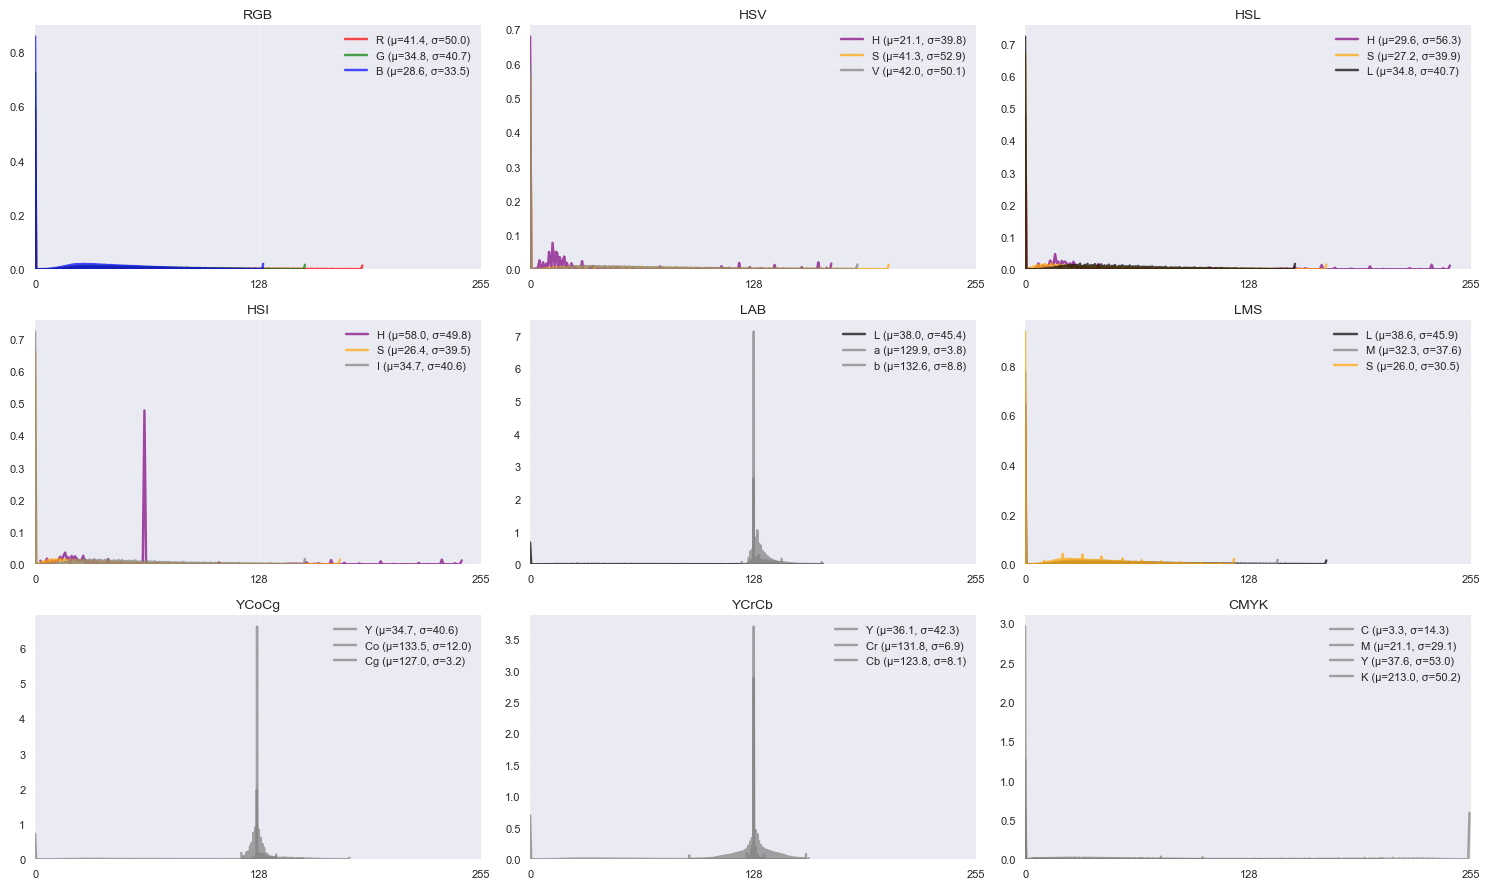

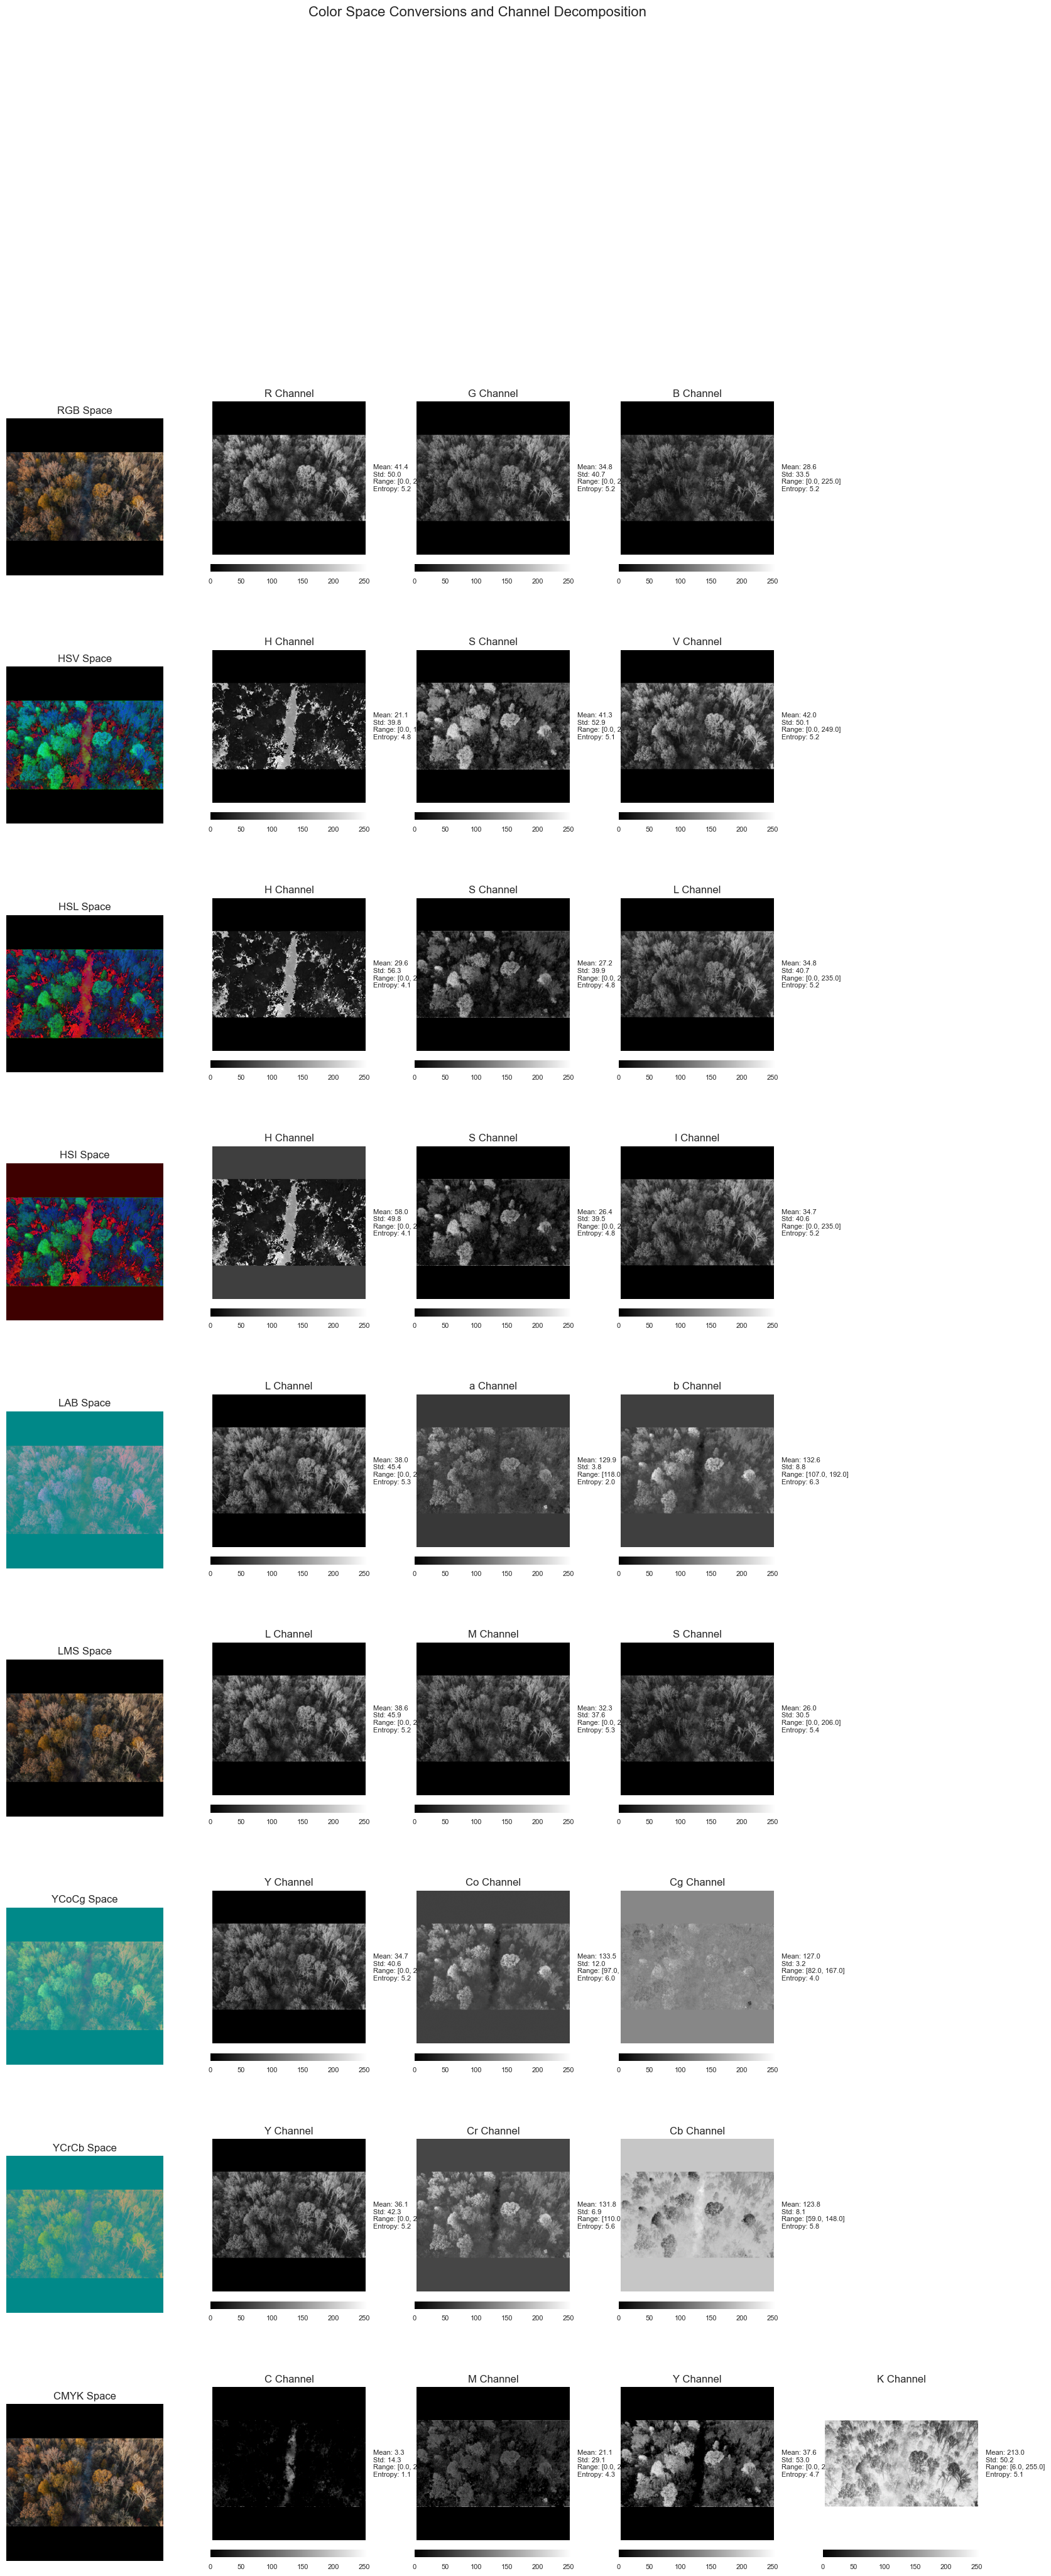

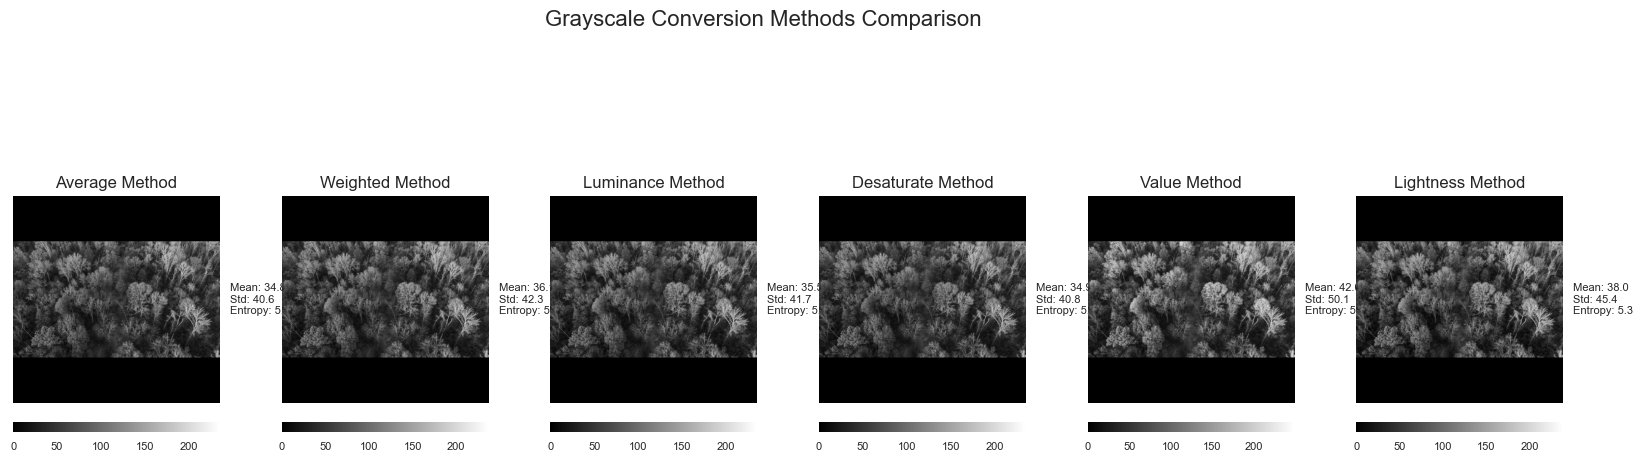

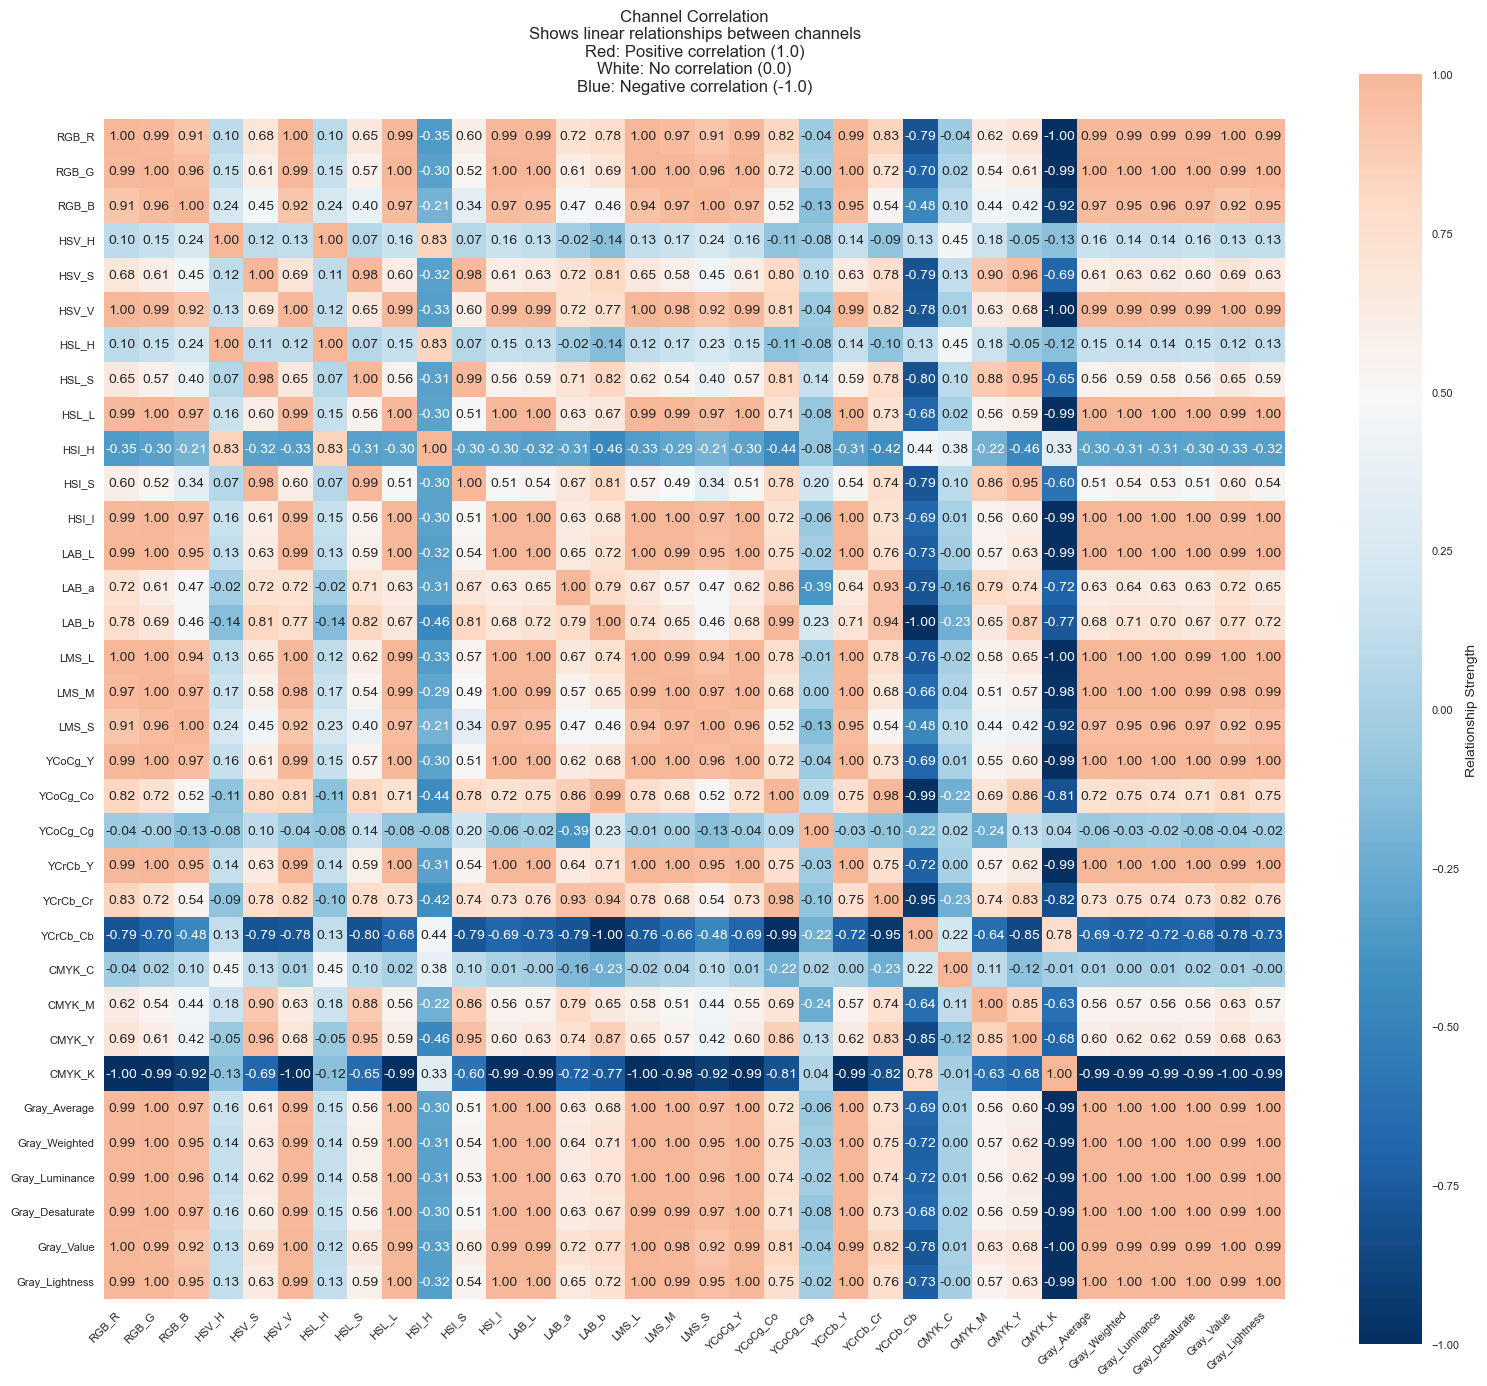


Strongest Channel Correlation relationship:
LAB_L and Gray_Lightness: 1.000

Weakest Channel Correlation relationship:
HSV_V and CMYK_K: -1.000


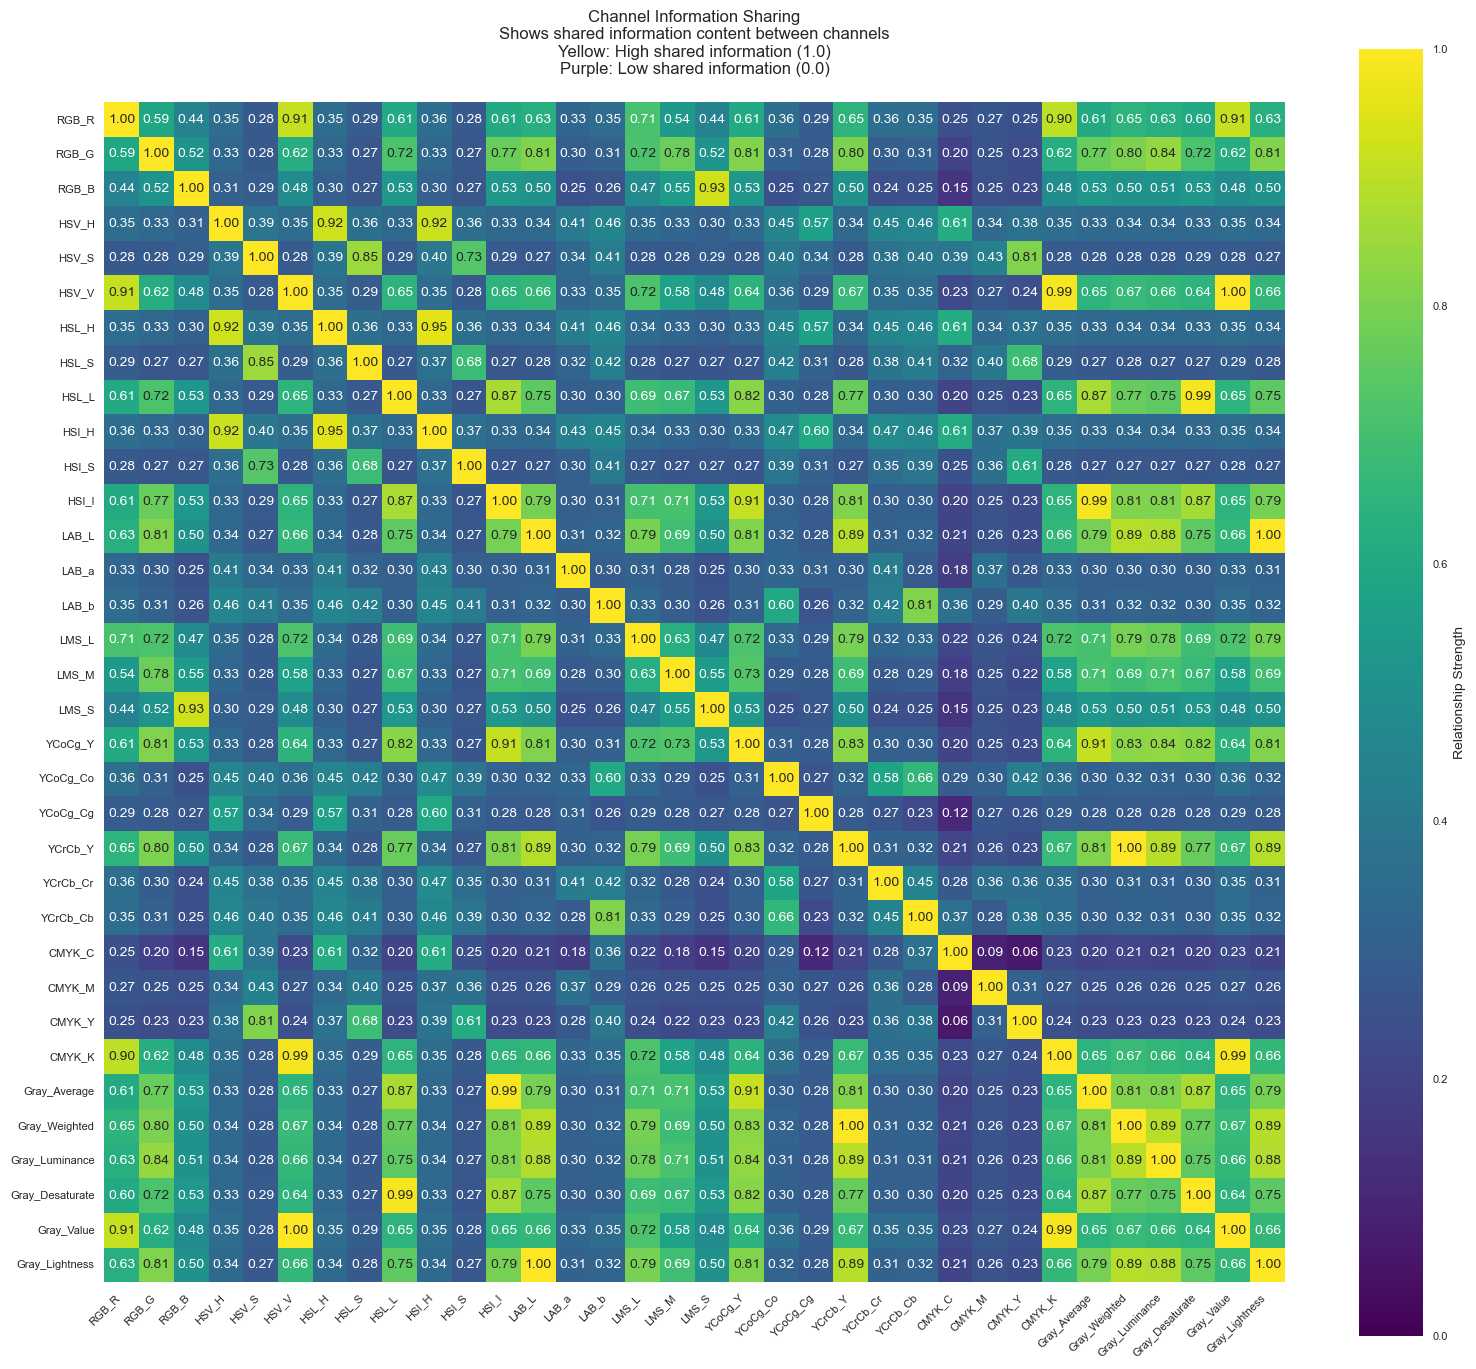


Strongest Channel Information Sharing relationship:
HSV_V and Gray_Value: 1.000

Weakest Channel Information Sharing relationship:
CMYK_C and CMYK_Y: 0.065


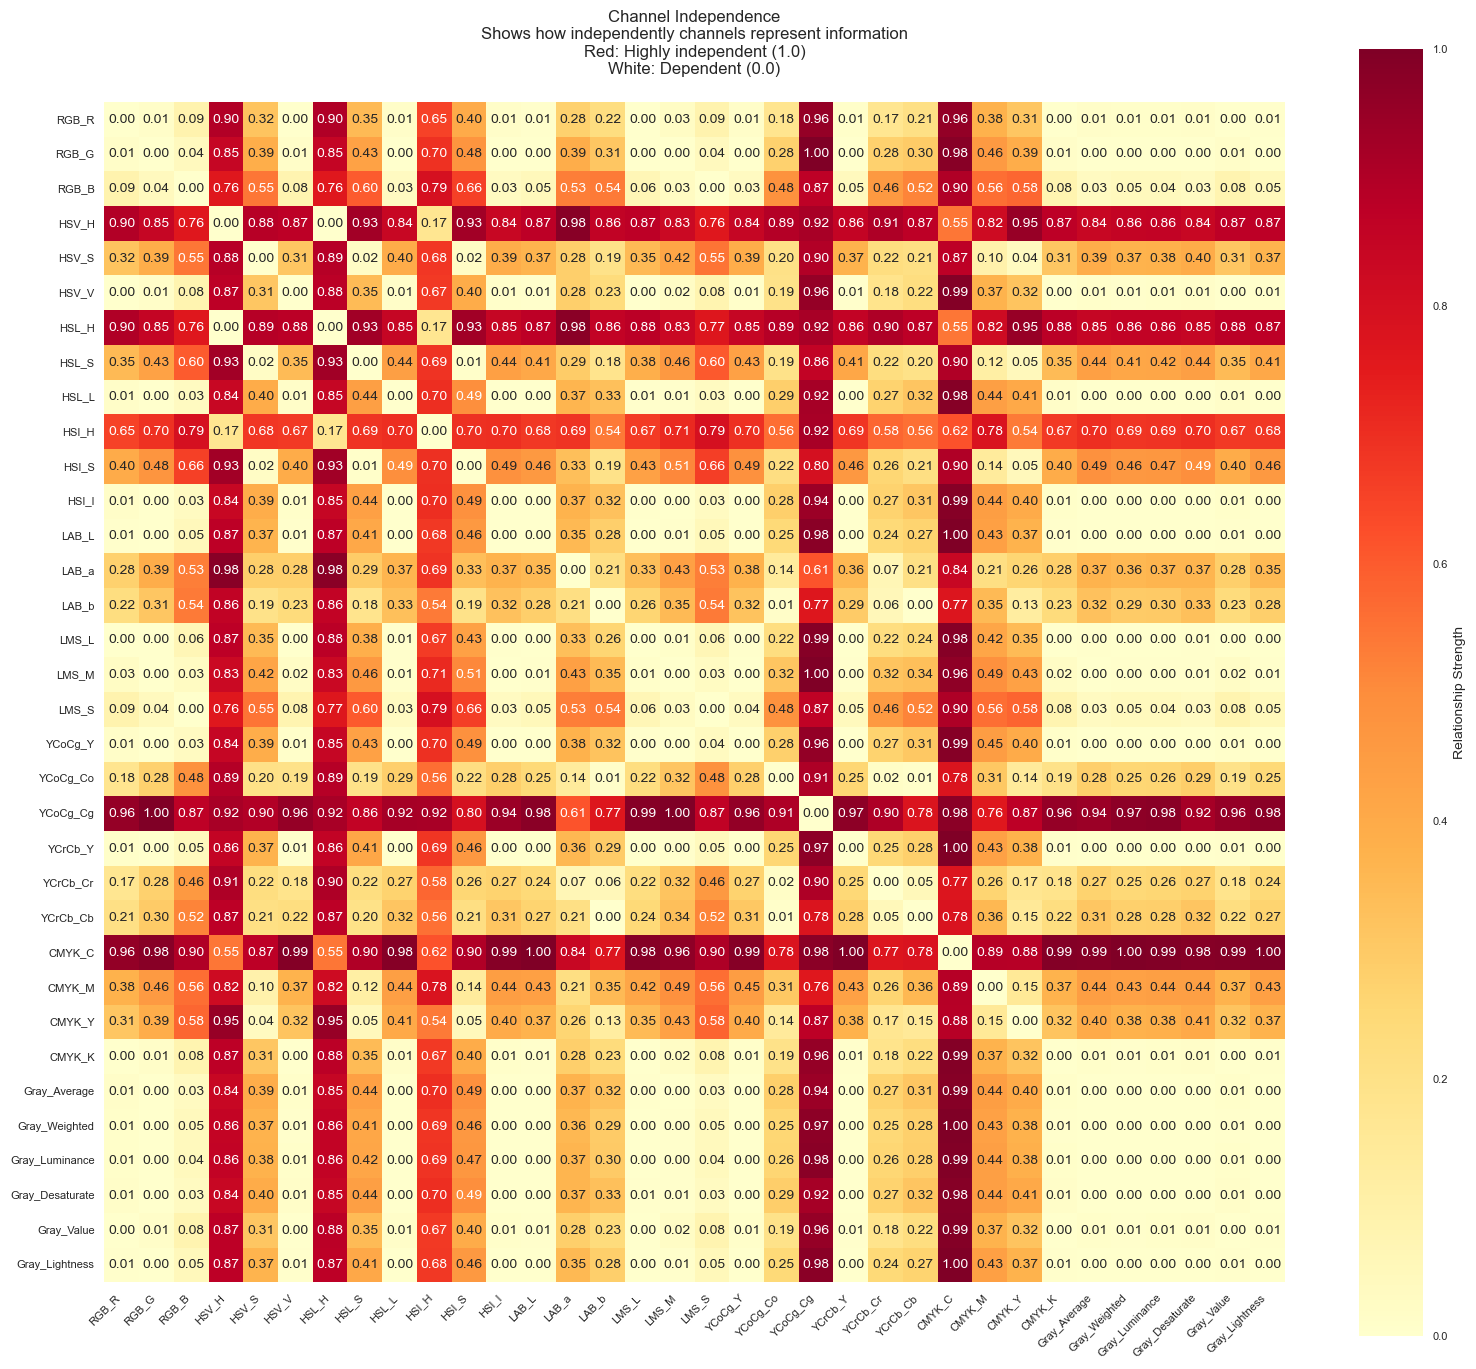


Strongest Channel Independence relationship:
YCrCb_Y and CMYK_C: 0.997

Weakest Channel Independence relationship:
LAB_L and Gray_Lightness: 0.000


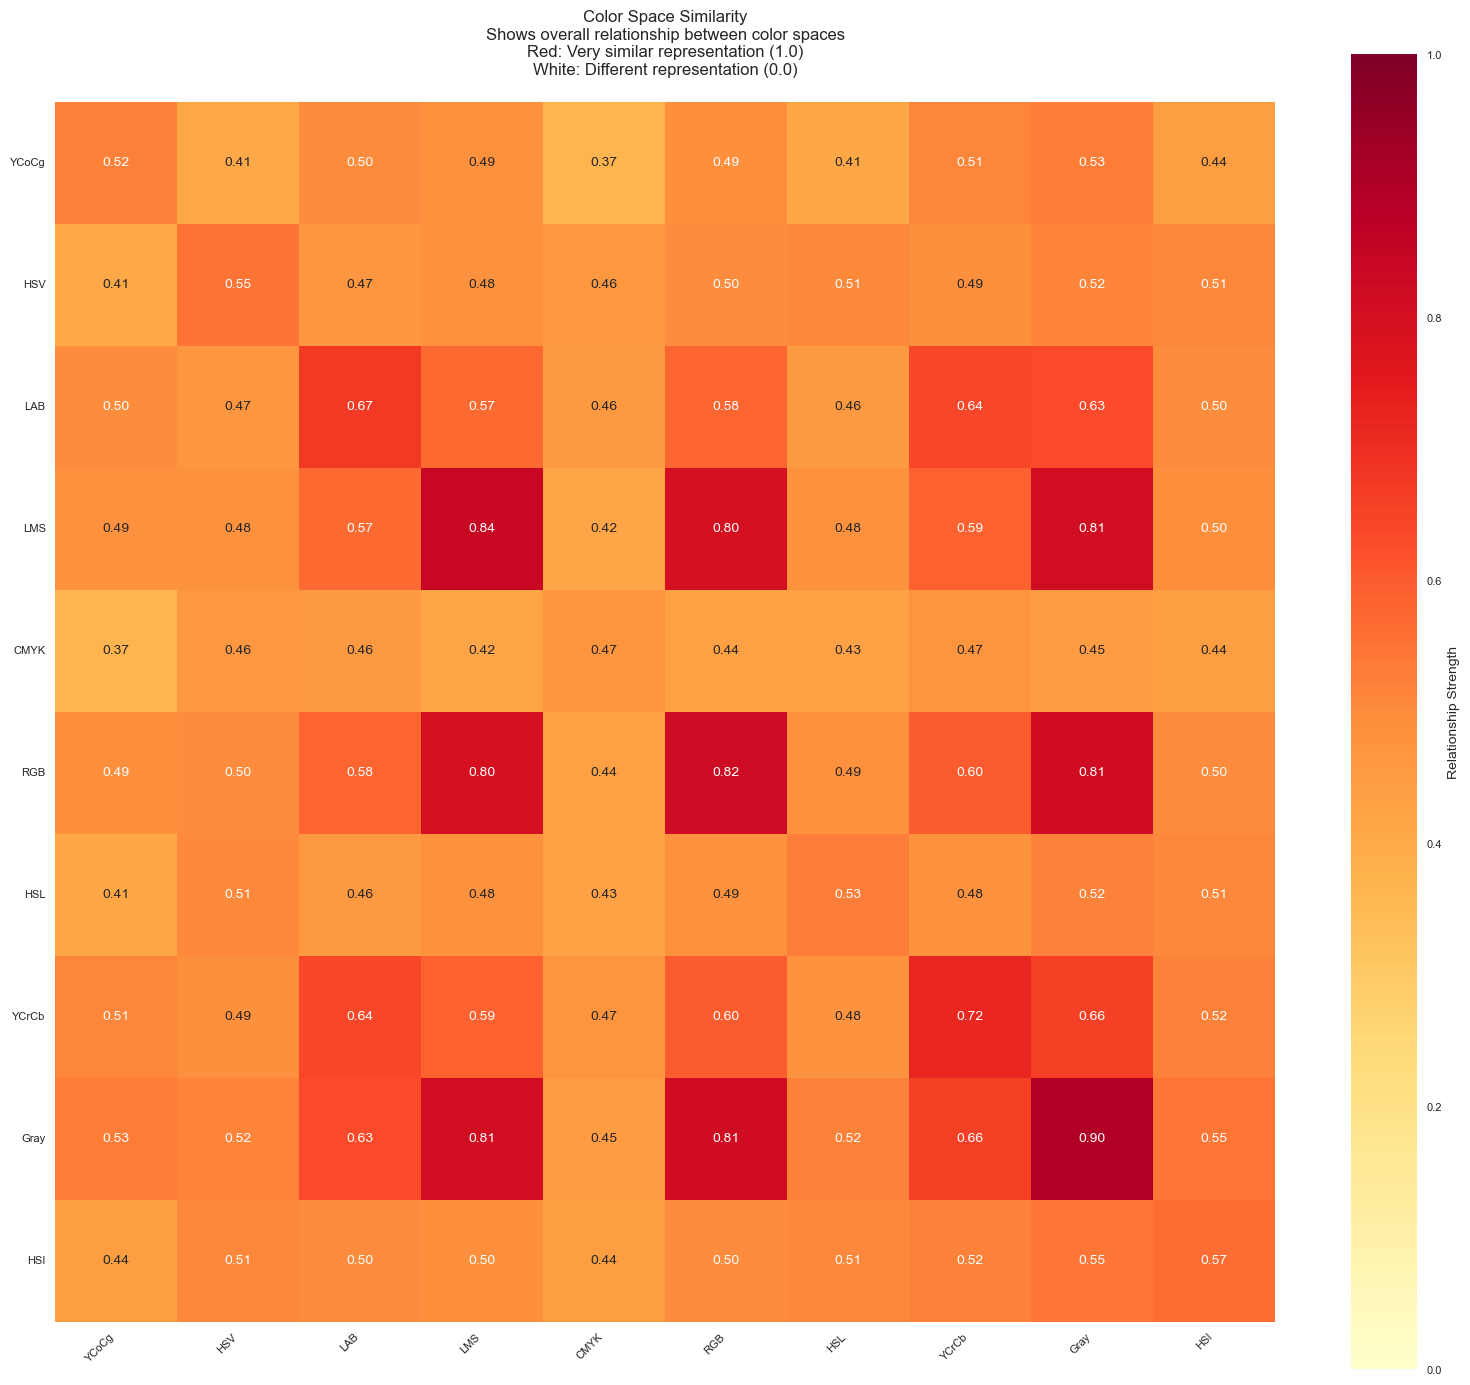


Strongest Color Space Similarity relationship:
RGB and Gray: 0.814

Weakest Color Space Similarity relationship:
YCoCg and CMYK: 0.367
Random image analysis completed: images/pexels-kelly-1179532-29740426.jpg


In [49]:
system = ColorAnalysisSystem()

try:
    print("\nAnalyzing random image...")
    random_results = system.analyze_random_image(
        image_dir="images",
        output_dir="random_analysis"
    )
    print(f"Random image analysis completed: {random_results['selected_image']}")
except Exception as e:
    print(f"Random image analysis failed: {str(e)}")